In [448]:
%matplotlib inline  

import os
import re
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import json

plt.rcParams["figure.figsize"] = (20,6)
plt.rcParams['font.size'] = 22

In [449]:
num_users = 100
frac = 0.1
local_ep = 1
unbalanced = True

global_ep = 1000

shard_per_user = 10

dataset = 'mnist'
#dataset = 'cifar10'
# dataset = 'cifar100'

In [450]:
if dataset == 'mnist':
    model = 'mlp'
else:
    model = 'cnn'

iid = False
if unbalanced:
    data_dict_fname = 'unbalanced_dict_users.pkl'
else:
    data_dict_fname = 'shared_dict_users.pkl'

    if shard_per_user == 10:
        iid = True

In [451]:
#save\mnist\mlp_iidTrue_num100_C0.1_le1\shard10\run1\fed
base_dir = './save/{}/{}_iid{}_num{}_C{}_le{}/shard{}/'.format(
    dataset, model, iid, num_users, frac, local_ep, shard_per_user)
runs = os.listdir(base_dir)
print(runs)
#runs = ['selection'] # diff data distribution
#runs = ['selection1', 'selection2', 'selection3', 'selection4', 'selection5']
#runs = ['selection1']
runs = ['unbalanced1']

['unbalanced_dict_users.pkl', 'unbalanced1']


In [452]:
data_dict_path = os.path.join(base_dir, data_dict_fname)
with open(data_dict_path, 'rb') as handle:
    (dict_users_train, dict_users_test) = pickle.load(handle)
local_data_size = []
for idx in range(num_users):
    local_data_size.append(len(dict_users_train[idx]))
print('local dataset size: ', local_data_size)

local dataset size:  [310, 299, 246, 404, 293, 312, 410, 248, 305, 486, 540, 598, 769, 413, 653, 488, 295, 597, 903, 418, 848, 853, 897, 608, 474, 548, 715, 602, 419, 708, 357, 1186, 852, 665, 853, 669, 529, 1032, 610, 788, 832, 851, 949, 836, 668, 721, 904, 945, 658, 878, 591, 650, 848, 783, 417, 723, 590, 801, 1260, 902, 587, 746, 1008, 712, 760, 1030, 642, 790, 616, 661, 533, 585, 853, 603, 711, 760, 667, 613, 353, 359, 364, 363, 556, 649, 539, 293, 363, 427, 472, 322, 484, 419, 235, 354, 304, 413, 174, 316, 295, 62]


In [453]:
rand_cnt = np.zeros(100)
slct_cnt = np.zeros(100)
max_ut = np.zeros(100)

def animate(i):
    #print(raw_ut[i])
    utility = json.loads(raw_ut[i])
    #print(utility)
    for j,(k,v) in enumerate(utility.items()):
        k_int = int(k)
        v_float = float(v)
        if v_float > max_ut[k_int]: max_ut[k_int] = v_float
        if i == 0:
            rand_cnt[k_int] += 1
        else:
            if j < 5:
                slct_cnt[k_int] += 1
            else:
                rand_cnt[k_int] += 1
               
    #rand_bar.set_data(range(num_users), rand_cnt)
    #slct_bar.set_data(range(num_users), slct_bar)
    return 
    
def plot_selection(fp):
    
    
    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca()
    
    global raw_ut
    raw_ut = fp.readlines()
    
    for t in range(global_ep-1):
        animate(t)
    #ani = animation.FuncAnimation(fig=fig, func=animate, frames=2000, interval=1000/N, blit=True, repeat=True)
    rand_bar = ax.bar(range(num_users), rand_cnt, width=0.5, label='rand')
    slct_bar = ax.bar(range(num_users), slct_cnt, width=0.5, label='slct', bottom=rand_cnt)
    for c in range(num_users):
        ax.text(c, rand_cnt[c]+slct_cnt[c]+1000/(slct_cnt[c]+8), "{:.2f}".format(max_ut[c]), color='gray', va='center', rotation=90, fontsize=15)
    ax.set_xlabel('client ID', fontsize=14)
    ax.set_ylabel('count', fontsize=14)
    ax.set_ylim([0, 2000])
    ax.legend()
    #plt.title('selection cnt - ' + str(shard_per_user) + ' class per client')
    plt.title('selection cnt - shard' + str(shard_per_user))
    plt.show()


===  unbalanced1  ===
   epoch  loss_avg  loss_test  acc_test  best_acc  time_local_avg  time_glob
0    0.0  2.298293   2.302029     11.47     11.47        0.222233   2.223467
1    1.0  2.296307   2.300536     16.57     16.57        0.285475   2.855897
2    2.0  2.279328   2.294974     14.53     16.57        0.265215   2.652982
3    3.0  2.214678   2.254723     21.01     21.01        0.266078   2.661531
4    4.0  2.098468   2.183890     29.42     29.42        0.241594   2.416734
(1000, 7)
fedavg, best_acc 98.13 ===================

   epoch  loss_avg  loss_test  acc_test  best_acc  time_local_avg  time_glob
0    0.0  2.298293   2.302029     11.47     11.47        0.210620   2.106965
1    1.0  2.294863   2.300875     12.61     12.61        0.269954   2.700449
2    2.0  2.284001   2.297427     14.33     14.33        0.307189   3.072799
3    3.0  2.211325   2.274763     14.27     14.33        0.307982   3.080645
4    4.0  2.128253   2.171507     36.15     36.15        0.306434   3.065190


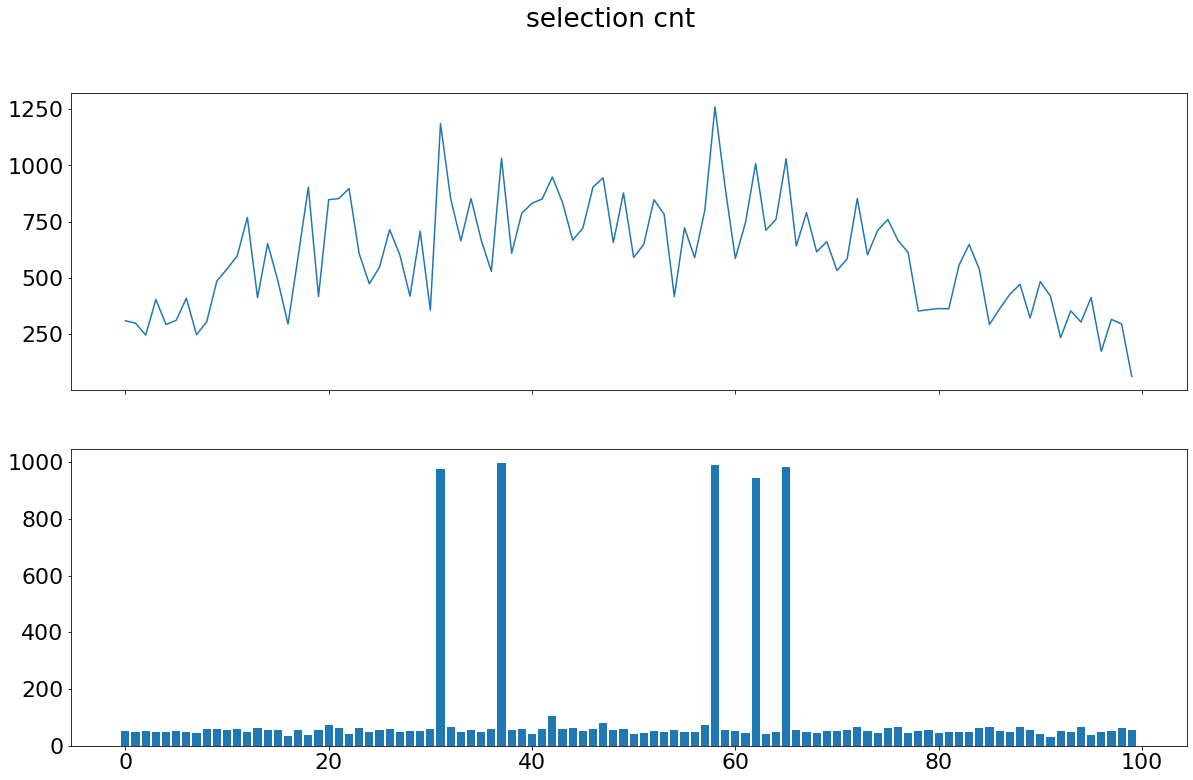

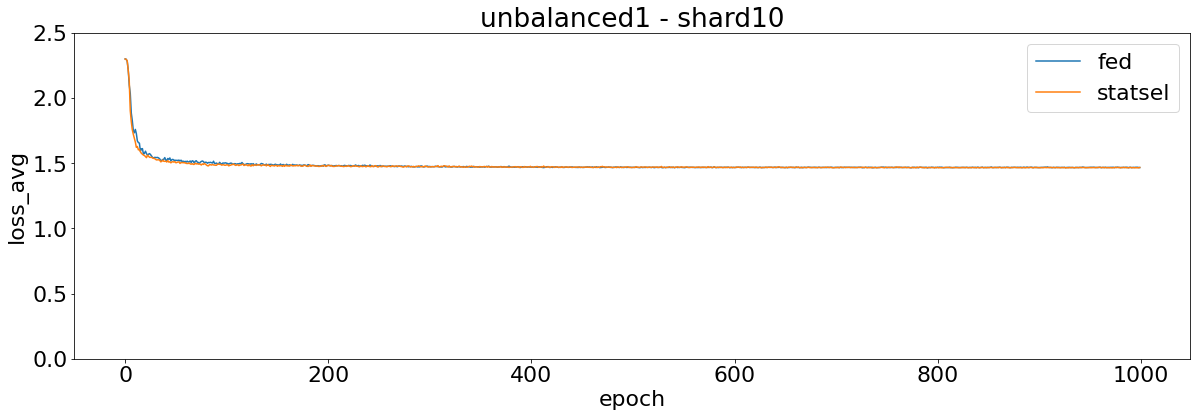

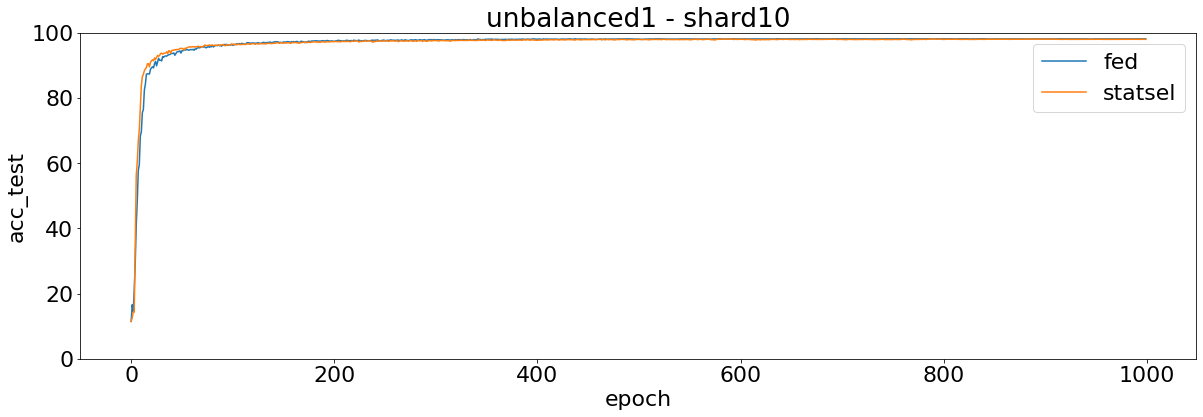

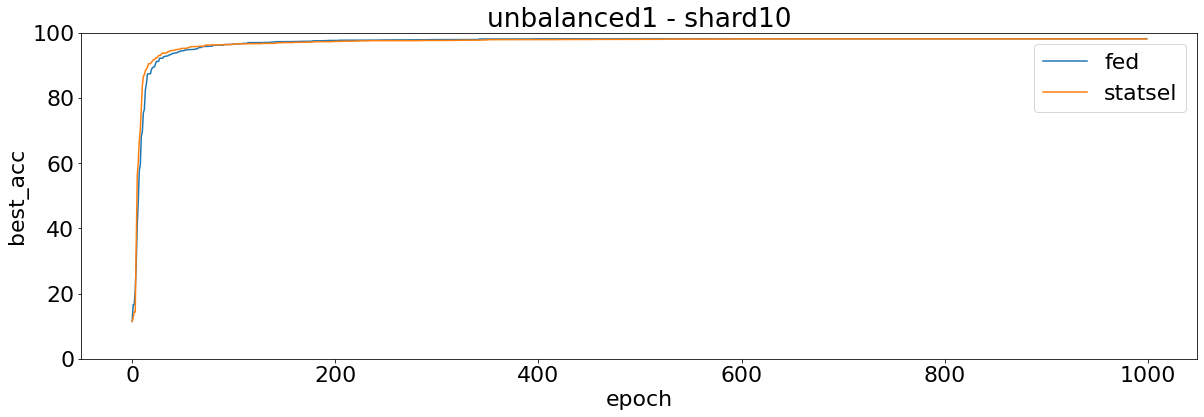

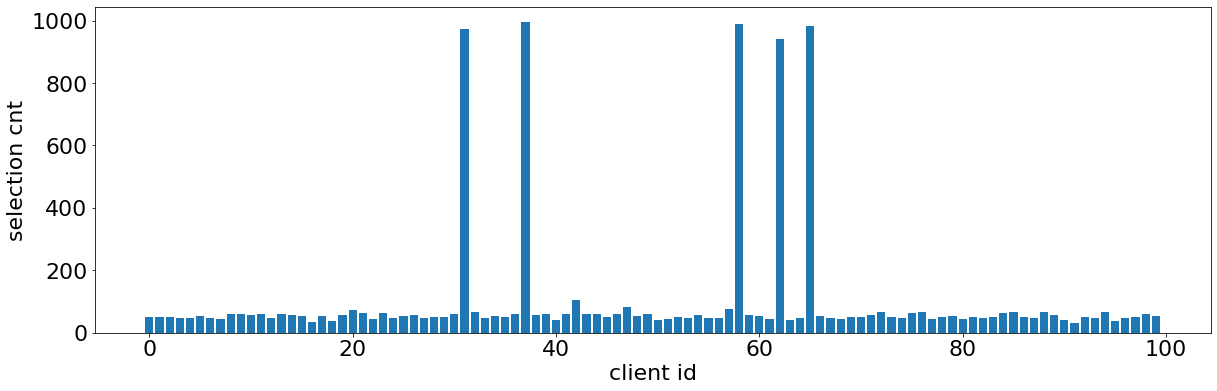

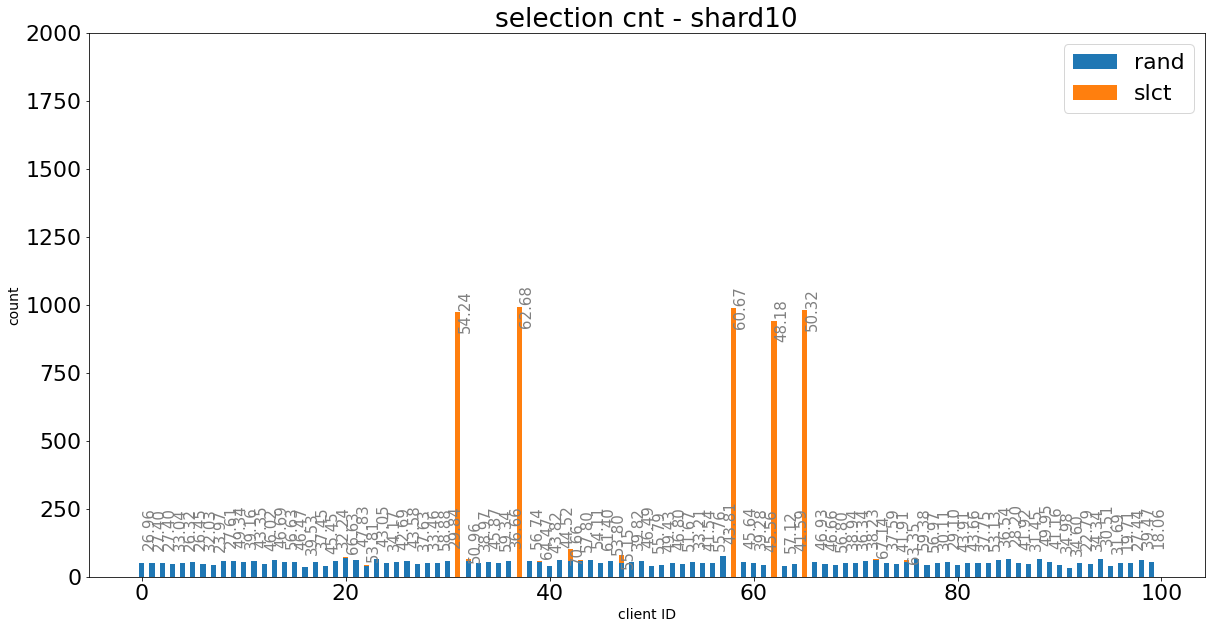

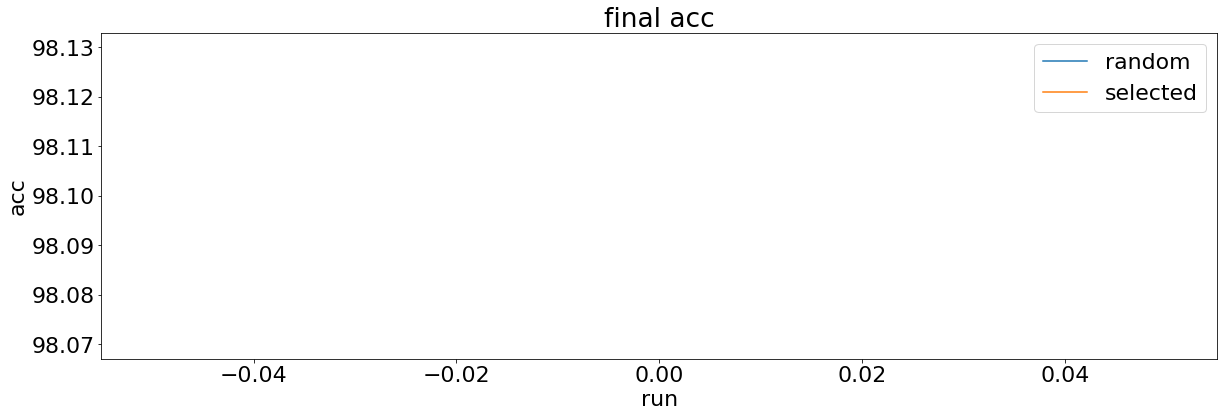

In [454]:
acc_fed = np.zeros(len(runs))
acc_statsel = np.zeros(len(runs))
acc_local_localtest = np.zeros(len(runs))
acc_local_newtest_avg = np.zeros(len(runs))
acc_local_newtest_ens = np.zeros(len(runs))
lg_metrics = {}

fig, axs = plt.subplots(len(runs)+1, sharex=True, figsize=(20, 12))
fig.suptitle('selection cnt')
axs[0].plot(range(len(local_data_size)), local_data_size,label='local data size')

for idx, run in enumerate(runs):
    print('=== ', run, ' ===')
    # FedAvg
    base_dir_fed = os.path.join(base_dir, "{}/fed".format(run))
    results_path_fed = os.path.join(base_dir_fed, "results.csv")
    df_fed = pd.read_csv(results_path_fed)
    print(df_fed.head())
    df_fed = df_fed[:global_ep]
    print(df_fed.shape)
    acc_fed[idx] = df_fed.loc[df_fed.shape[0]-1]['best_acc']
    print('fedavg, best_acc', acc_fed[idx], '===================')
    print('')
    
    # fedavg w/ statistical selection
    base_dir_statsel = os.path.join(base_dir, "{}/statsel".format(run))
    results_path_statsel = os.path.join(base_dir_statsel, "results.csv")
    slctcnt_path = os.path.join(base_dir_statsel, "selection_cnt.csv")
    utility_path = os.path.join(base_dir_statsel, "utility.csv")
    df_statsel = pd.read_csv(results_path_statsel)
    slctcnt = np.genfromtxt(slctcnt_path, delimiter=',')
    utility = np.genfromtxt(utility_path, delimiter='\n')

    print(df_statsel.head())
    df_statsel = df_statsel[:global_ep]
    print(df_statsel.shape)
    acc_statsel[idx] = df_statsel.loc[df_statsel.shape[0]-1]['best_acc']
    print('statsel, best_acc', acc_statsel[idx], '===================')
    print('')
    

    #['loss_avg', 'loss_test', 'acc_test', 'best_acc']
    plt.rcParams["figure.figsize"] = (20,6)
    
    for col, yl in [('loss_avg',[0, 2.5]), ('acc_test', [0, 100]), ('best_acc', [0, 100])]:
        plt.figure()
        plt.plot(df_fed['epoch'], df_fed[col], label='fed')
        plt.plot(df_statsel['epoch'], df_statsel[col], label='statsel')
        plt.legend()
        plt.ylabel(col)
        plt.xlabel('epoch')
        plt.ylim(yl)
        plt.title(run + ' - shard' + str(shard_per_user))
        #plt.title(run + ' - ' + str(shard_per_user) + ' class per client')
    
    
    plt.figure()
    plt.bar(range(len(slctcnt)), slctcnt)
    plt.ylabel('selection cnt')
    plt.xlabel('client id')
    
    axs[idx+1].bar(range(len(slctcnt)), slctcnt)
    with open(utility_path) as fp_utility:
        plot_selection(fp_utility)



    
plt.rcParams["figure.figsize"] = (20,6)
#plt.rcParams['font.size'] = 22
plt.figure()
plt.title('final acc')
plt.plot(range(len(acc_fed)), acc_fed, label='random')    
plt.plot(range(len(acc_statsel)), acc_statsel, label='selected')
plt.xlabel('run')
plt.ylabel('acc')
plt.legend()


In [428]:
columns = ["Run", "Local Test", "New Test (avg)", "New Test (ens)", "FedAvg Rounds", "LG Rounds"]
results = []

In [ ]:
str_acc_local_localtest = "{:.2f} +- {:.2f}".format(acc_local_localtest.mean(), acc_local_localtest.std())
str_acc_local_newtest_avg = "{:.2f} +- {:.2f}".format(acc_local_newtest_avg.mean(), acc_local_newtest_avg.std())
str_acc_local_newtest_ens = "{:.2f} +- {:.2f}".format(acc_local_newtest_ens.mean(), acc_local_newtest_ens.std())

print("localonly:\t", str_acc_local_localtest)
print("localonly_avg:\t", str_acc_local_newtest_avg)
print("localonly_ens:\t", str_acc_local_newtest_ens)

results.append(["LocalOnly", str_acc_local_localtest, str_acc_local_newtest_avg, str_acc_local_newtest_ens, 0, 0])

In [ ]:
for lg_run in sorted(lg_metrics.keys()):
    x = ["LG-FedAvg"]
    print(lg_run)
    for array in ['acc_local', 'acc_avg', 'acc_ens']:
        mean = lg_metrics[lg_run][array].mean()
        std = lg_metrics[lg_run][array].std()
        str_acc = "{:.2f} +- {:.2f}".format(mean, std)
        print("{}:\t{}".format(array, str_acc))
        
        x.append(str_acc)
    x.append(lg_run)
    x.append(rd_lg)
    results.append(x)

In [ ]:
str_acc_fed = "{:.2f} +- {:.2f}".format(acc_fed.mean(), acc_fed.std())
print("fed:\t", str_acc_fed)
results.append(["FedAvg", str_acc_fed, str_acc_fed, str_acc_fed, rd_fed, 0])

In [5]:
pd.DataFrame(results, columns=columns).set_index("Run")

NameError: name 'results' is not defined